In [0]:
%matplotlib inline

In [2]:
!git clone https://github.com/TejasMorbagal/DenseNet.git

Cloning into 'DenseNet'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 1571 (delta 0), reused 0 (delta 0), pack-reused 1568
Receiving objects: 100% (1571/1571), 433.89 MiB | 38.62 MiB/s, done.
Resolving deltas: 100% (22/22), done.
Checking out files: 100% (1490/1490), done.


In [0]:


from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'DenseNet/Dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

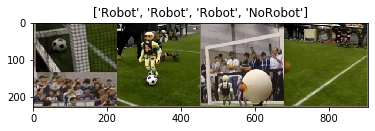

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
model_ft = models.densenet121(pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 64.4MB/s]


In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.1516 Acc: 0.9553
val Loss: 0.4776 Acc: 0.7939

Epoch 1/19
----------
train Loss: 0.1168 Acc: 0.9644
val Loss: 0.1702 Acc: 0.9333

Epoch 2/19
----------
train Loss: 0.0918 Acc: 0.9697
val Loss: 0.2470 Acc: 0.8909

Epoch 3/19
----------
train Loss: 0.0836 Acc: 0.9644
val Loss: 0.2671 Acc: 0.8727

Epoch 4/19
----------
train Loss: 0.0806 Acc: 0.9682
val Loss: 0.3899 Acc: 0.7879

Epoch 5/19
----------
train Loss: 0.0744 Acc: 0.9629
val Loss: 0.1630 Acc: 0.9394

Epoch 6/19
----------
train Loss: 0.0623 Acc: 0.9750
val Loss: 0.2119 Acc: 0.8970

Epoch 7/19
----------
train Loss: 0.0583 Acc: 0.9735
val Loss: 0.2503 Acc: 0.8848

Epoch 8/19
----------
train Loss: 0.0612 Acc: 0.9720
val Loss: 0.2079 Acc: 0.9091

Epoch 9/19
----------
train Loss: 0.0503 Acc: 0.9803
val Loss: 0.1885 Acc: 0.9091

Epoch 10/19
----------
train Loss: 0.0498 Acc: 0.9796
val Loss: 0.2163 Acc: 0.9030

Epoch 11/19
----------
train Loss: 0.0533 Acc: 0.9780
val Loss: 0.1891 Acc: 0.9152

Epoch 12/19
----------
t

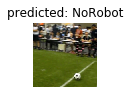

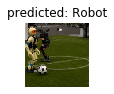

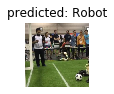

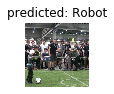

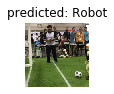

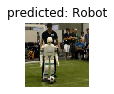

In [12]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.






In [0]:
model_conv = torchvision.models.densenet121(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier.in_features
model_conv.classifier = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [14]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.1663 Acc: 0.9516
val Loss: 0.3744 Acc: 0.8061

Epoch 1/19
----------
train Loss: 0.1246 Acc: 0.9614
val Loss: 0.5042 Acc: 0.7758

Epoch 2/19
----------
train Loss: 0.1249 Acc: 0.9569
val Loss: 0.2399 Acc: 0.9212

Epoch 3/19
----------
train Loss: 0.1124 Acc: 0.9576
val Loss: 0.4608 Acc: 0.8061

Epoch 4/19
----------
train Loss: 0.1181 Acc: 0.9621
val Loss: 0.4167 Acc: 0.8364

Epoch 5/19
----------
train Loss: 0.1113 Acc: 0.9606
val Loss: 0.3991 Acc: 0.8424

Epoch 6/19
----------
train Loss: 0.0945 Acc: 0.9674
val Loss: 0.3751 Acc: 0.8545

Epoch 7/19
----------
train Loss: 0.0902 Acc: 0.9637
val Loss: 0.3485 Acc: 0.8545

Epoch 8/19
----------
train Loss: 0.0868 Acc: 0.9637
val Loss: 0.2849 Acc: 0.8788

Epoch 9/19
----------
train Loss: 0.0884 Acc: 0.9644
val Loss: 0.3181 Acc: 0.8667

Epoch 10/19
----------
train Loss: 0.0918 Acc: 0.9637
val Loss: 0.3282 Acc: 0.8667

Epoch 11/19
----------
train Loss: 0.0942 Acc: 0.9629
val Loss: 0.3114 Acc: 0.8788

Epoch 12/19
----------
t

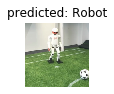

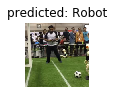

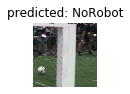

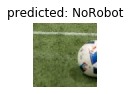

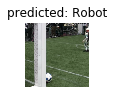

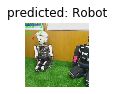

In [15]:
visualize_model(model_conv)

plt.ioff()
plt.show()